In \[37\]:

    #일단 주신 데이터 파일 법정동 데이터 기반으로 맵핑했어요
    import pandas as pd
    import folium
    from sklearn.cluster import DBSCAN

    # 데이터 불러오기
    df = pd.read_csv('data.csv',encoding='euc-kr')
    df_frame = df[['법정동', 'Latitude', 'Longitude']]

    # 지도 초기 위치 설정
    map = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=12)

    # 동 이름과 좌표 정보를 지도에 추가
    for i in df.index:
        dong = df.loc[i, '법정동']
        lat = df.loc[i, 'Latitude']
        long = df.loc[i, 'Longitude']
        folium.Marker([lat, long], popup=dong).add_to(map)

    # 지도 보여주기
    map

Out\[37\]:

<span style="color:#565656">Make this Notebook Trusted to load map: File
-\> Trust Notebook</span>

In \[40\]:

    #인구수 기반 dbscan
    import pandas as pd
    import folium
    from sklearn.cluster import DBSCAN
    import numpy as np

    # 엑셀 파일 읽어오기
    df = pd.read_csv('data.csv',encoding='euc-kr')

    # 맵핑할 초기 위치 설정 (서울 중심)
    seoul_lat, seoul_lon = 37.566345, 126.977893

    # folium 지도 생성f
    kluster_mapping = folium.Map(location=[seoul_lat, seoul_lon], zoom_start=11)

    # 인구수 데이터에 대해 DBSCAN 클러스터링
    X = df[['인구수']]
    db = DBSCAN(eps=5000, min_samples=3).fit(X)

    # 클러스터링 결과에 대해 라벨링 및 색상 부여
    labels = db.labels_
    unique_labels = set(labels)

    # 각 클러스터의 중심좌표 계산
    cluster_centers = []
    for label in unique_labels:
        if label != -1:
            X_temp = X[labels == label]
            center = np.mean(X_temp, axis=0)
            cluster_centers.append(center)

    # 클러스터 중심좌표에 대해 마커 생성
    for i, center in enumerate(cluster_centers):
        folium.Marker(
            location=[df['Latitude'].iloc[i], df['Longitude'].iloc[i]],
            popup=f'Cluster {i+1}',
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(kluster_mapping)

    # 지도 출력
    kluster_mapping

Out\[40\]:

<span style="color:#565656">Make this Notebook Trusted to load map: File
-\> Trust Notebook</span>

In \[43\]:

    #kmeans++사용전 elbow method를 사용해서 클러스터 갯수 미리 정하기
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    # 데이터 로드
    df = pd.read_csv('data.csv', encoding='euc-kr')

    # 데이터 전처리
    X = df[['인구수', 'Latitude', 'Longitude']].values

    # Elbow 기법을 사용하여 최적의 클러스터 개수 찾기
    inertia = []
    k_range = range(1, 11)  # 원하는 클러스터 개수 범위 설정

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    # Elbow 그래프 그리기
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

    C:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
      warnings.warn(

![](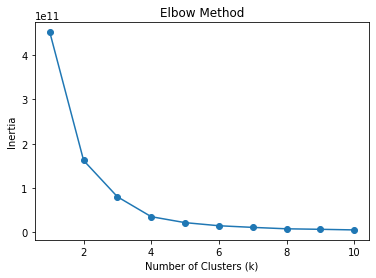%0A)

In \[48\]:

    #elbow method 도표만으로 elbow point 식별이 어려워 silhouette_score 사용해서 클러스터 갯수 구했어요
    import numpy as np
    import pandas as pd
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    # 데이터 로드
    df = pd.read_csv('data.csv', encoding='euc-kr')

    # 데이터 전처리
    X = df[['Latitude', 'Longitude']]
    weights = df['인구수'].values

    # K-means 클러스터링과 실루엣 점수 계산을 위한 반복문
    max_clusters = 10  # 최대 클러스터 개수 설정
    best_score = -1  # 최고 실루엣 점수 초기값 설정
    best_clusters = 0  # 최고 실루엣 점수에 해당하는 클러스터 개수 초기값 설정

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(X, sample_weight=weights)
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(X, cluster_labels)
        
        # 실루엣 점수가 최고값인 경우 결과 저장
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_clusters = n_clusters

    # 최고 실루엣 점수에 해당하는 클러스터 개수로 K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=best_clusters, init='k-means++', random_state=42).fit(X, sample_weight=weights)
    df['cluster'] = kmeans.labels_

    # 클러스터링 결과 시각화 등 추가 작업 수행

    # 최적의 클러스터 개수와 실루엣 점수 출력
    print("Optimal number of clusters:", best_clusters)
    print("Silhouette score:", best_score)

    Optimal number of clusters: 2
    Silhouette score: 0.4045046352929547

In \[46\]:

    #앞선 실루엣 스코어를 기반으로 나온 클러스터 수가 2개 / 너무 적어서 클러스터 갯수별 실루엣 스코어 뽑아봤어요 
    # 클러스터 7개일때 그나마 실루엣 스코어 값이 높은데 7로 하는건 어떨까요
    import numpy as np
    import pandas as pd
    import folium
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    # 데이터 로드
    df = pd.read_csv('data.csv',encoding='euc-kr')

    # 서울 중심 좌표
    seoul_lat, seoul_lon = 37.566345, 126.977893

    # folium 지도 객체 생성
    kluster_map = folium.Map(location=[seoul_lat, seoul_lon], zoom_start=11)

    # k-means 클러스터링
    X = df[['Latitude', 'Longitude']]
    weights = df['인구수'].values
    max_clusters = 15
    silhouette_scores = np.zeros((max_clusters-2,))

    for i in range(2, max_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42).fit(X, sample_weight=weights)
        df['cluster'] = kmeans.labels_
        
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores[i-2] = silhouette_avg
        print(f"Done with cluster size {i}. Silhouette score: {silhouette_avg}")
        
        sample_silhouette_values = silhouette_samples(X, kmeans.labels_)

        # 클러스터링 결과 시각화
        cluster_centers = kmeans.cluster_centers_  # 클러스터 중심 좌표

        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        y_lower = 10
        for j in range(i):
            ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == j]
            ith_cluster_silhouette_values.sort()
            size_cluster_j = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_j
            color = cm.nipy_spectral(float(j) / i)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
            y_lower = y_upper + 10

        ax.set_title("The silhouette plot for the various clusters.", fontsize=14)
        ax.set_xlabel("The silhouette coefficient values", fontsize=12)
        ax.set_ylabel("Cluster label", fontsize=12)
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_yticks([])  
        ax.set_xlim([-0.1, 1])

        plt.show()

    # 실루엣 스코어 시각화
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(7, 7)

    ax.plot(range(2, max_clusters), silhouette_scores)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette score')
    ax.set_xticks(range(2, max_clusters))
    ax.set_title('Silhouette score for each cluster size')

    plt.show()

    Done with cluster size 2. Silhouette score: 0.4045046352929547

![](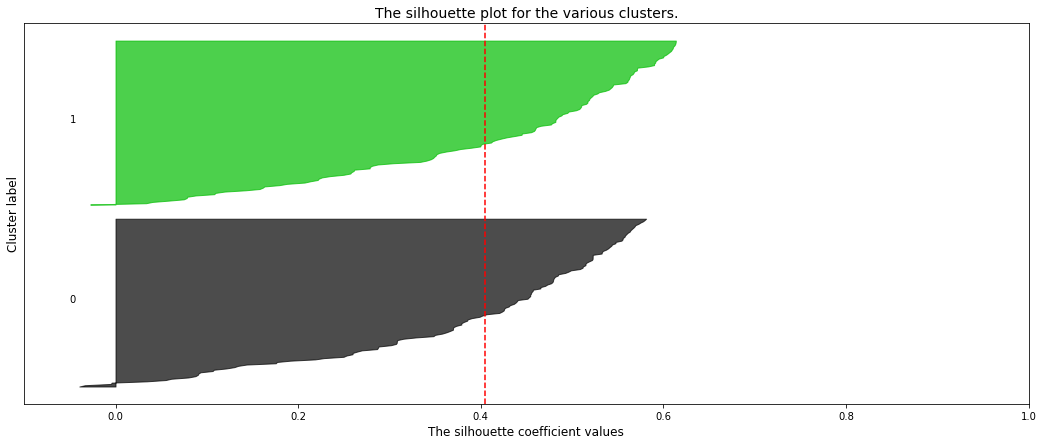%0A)

    Done with cluster size 3. Silhouette score: 0.3163666820615192

![](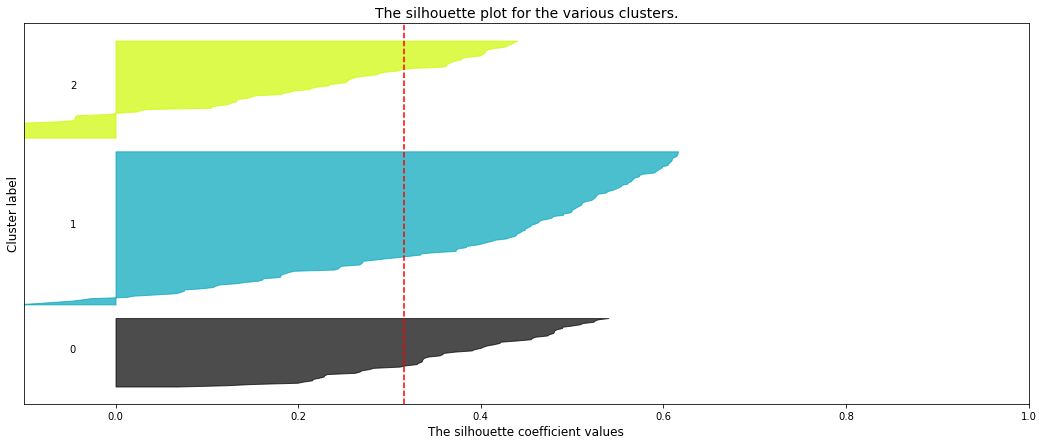%0A)

    Done with cluster size 4. Silhouette score: 0.27639217395540133

![](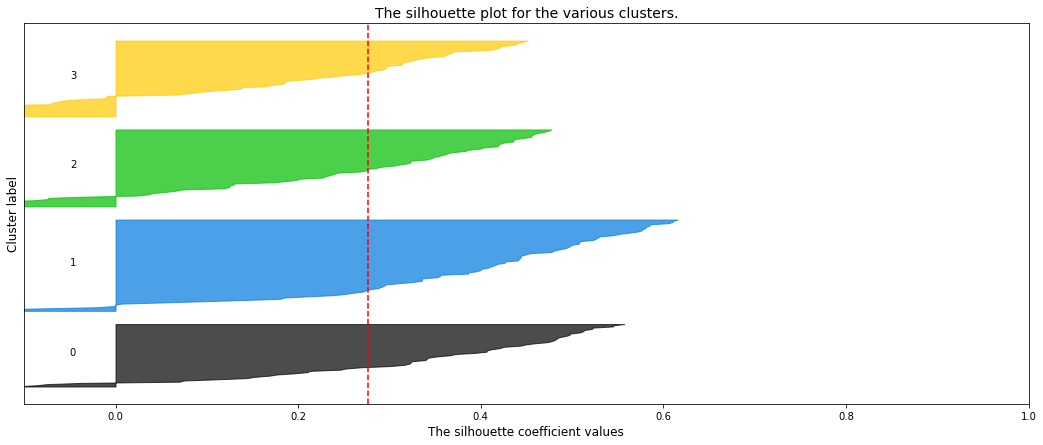%0A)

    Done with cluster size 5. Silhouette score: 0.29645206768596677

![](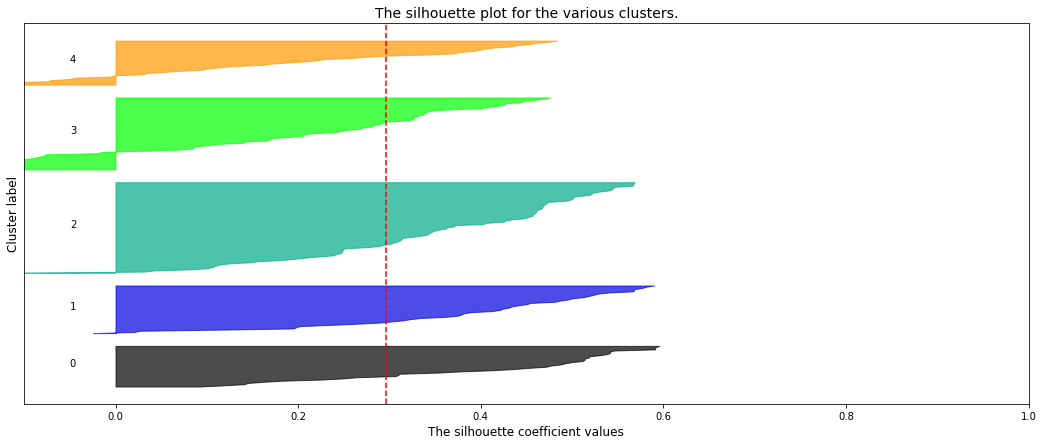%0A)

    Done with cluster size 6. Silhouette score: 0.3021191284553947

![](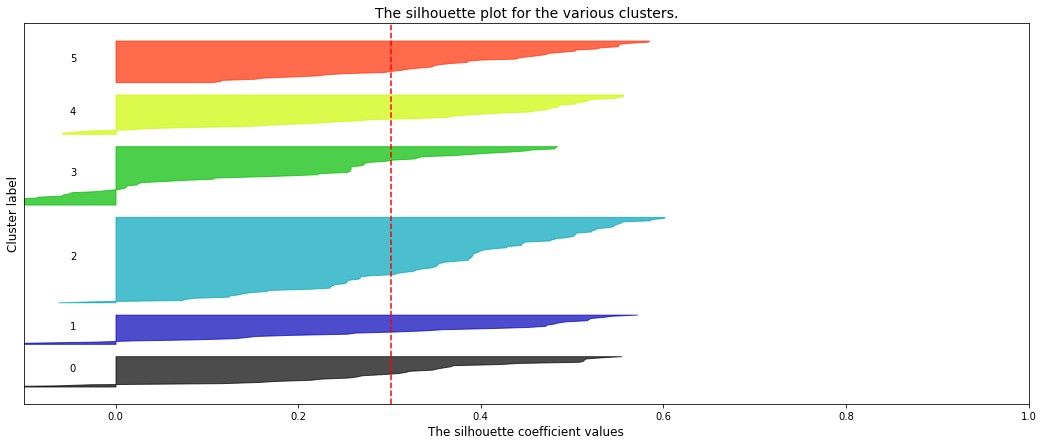%0A)

    Done with cluster size 7. Silhouette score: 0.3175490747980975

![](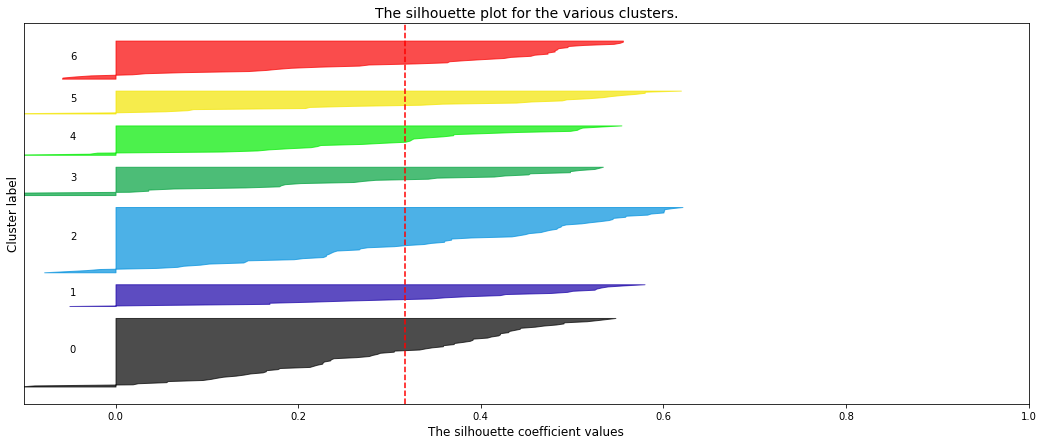%0A)

    Done with cluster size 8. Silhouette score: 0.31552519961161307

![](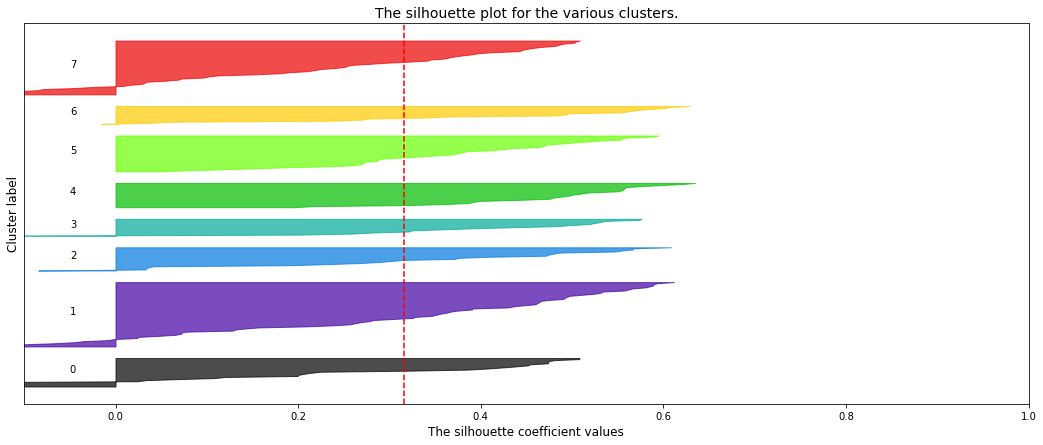%0A)

    Done with cluster size 9. Silhouette score: 0.3146759044144633

![](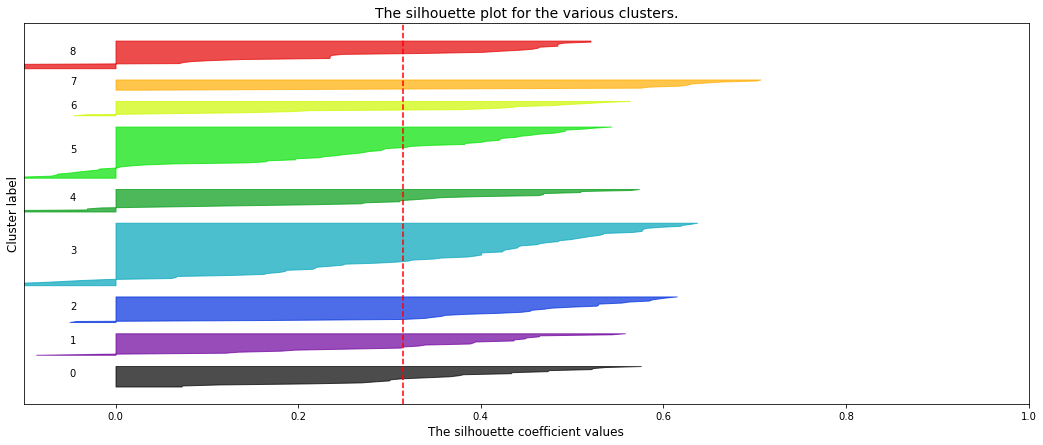%0A)

    Done with cluster size 10. Silhouette score: 0.29666016625637126

![](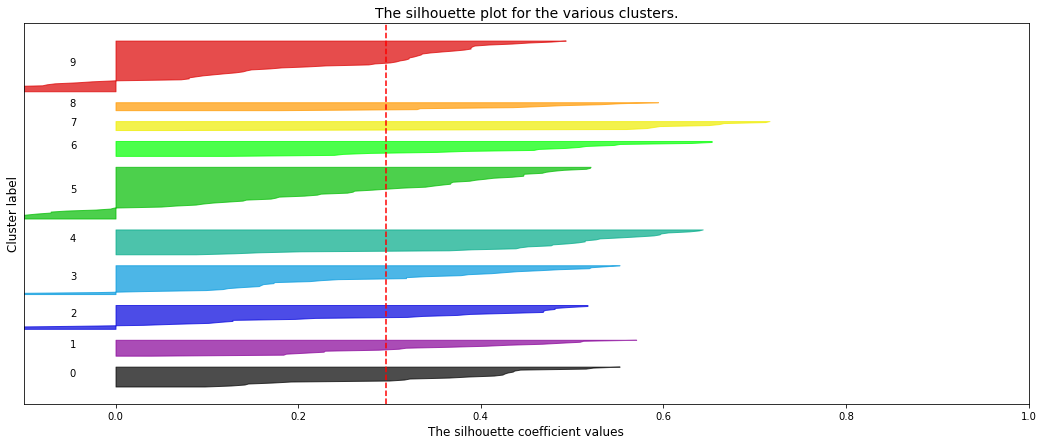%0A)

    Done with cluster size 11. Silhouette score: 0.3094243498429601

![](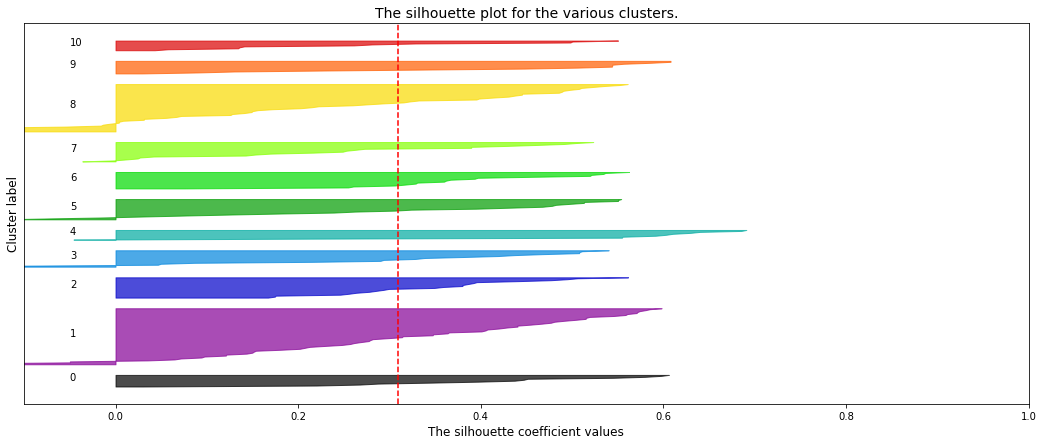%0A)

    Done with cluster size 12. Silhouette score: 0.3174452832447343

![](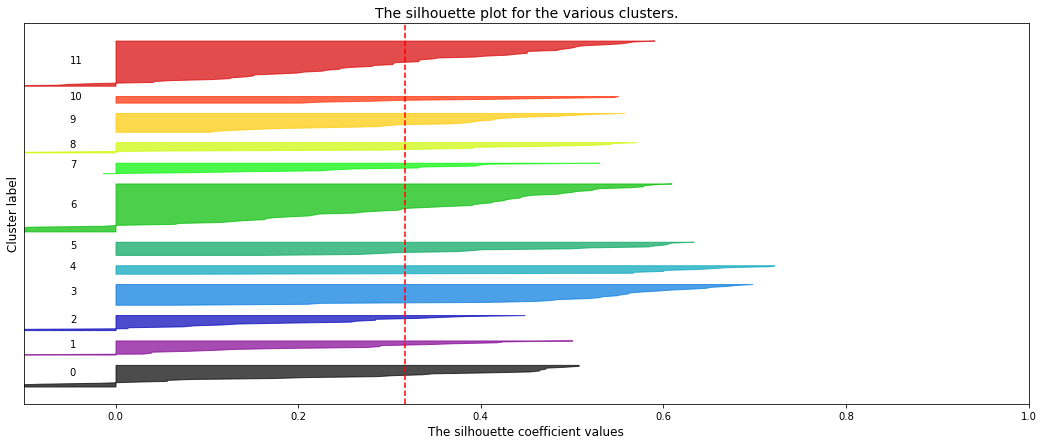%0A)

    Done with cluster size 13. Silhouette score: 0.32818083477044385

![](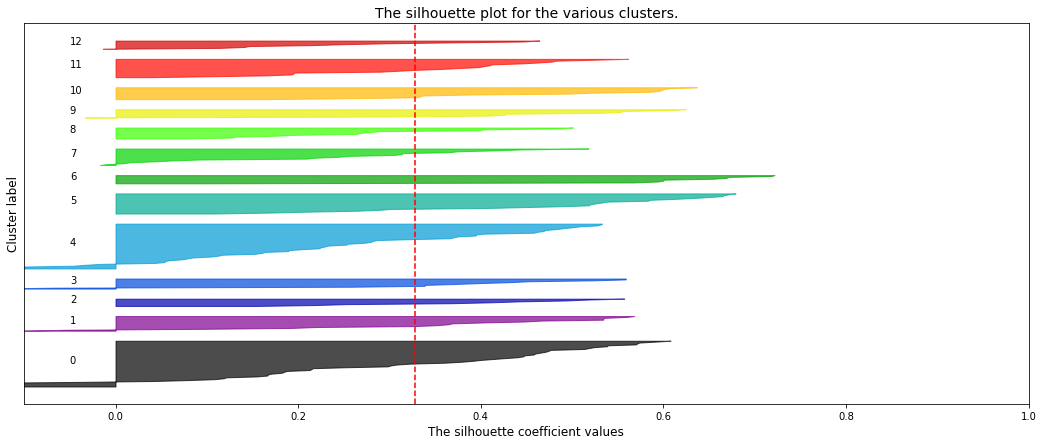%0A)

    Done with cluster size 14. Silhouette score: 0.3462330160895603

![](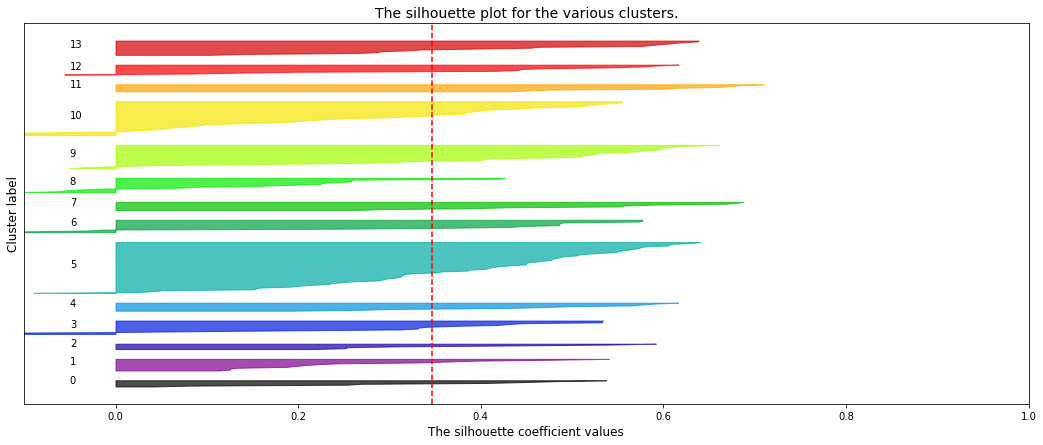%0A)

![](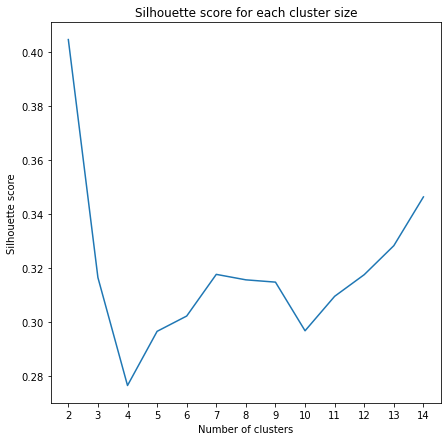%0A)

In \[49\]:

    #elbow method 사용 결과값을 바탕으로 인구수에 가중치를 준 kmeans++ 클러스터링
    import numpy as np
    import pandas as pd
    import folium
    from sklearn.cluster import KMeans

    # 데이터 로드
    df = pd.read_csv('data.csv',encoding='euc-kr')

    # 서울 중심 좌표
    seoul_lat, seoul_lon = 37.566345, 126.977893

    # folium 지도 객체 생성
    kluster_map = folium.Map(location=[seoul_lat, seoul_lon], zoom_start=11)

    # k-means 클러스터링
    X = df[['Latitude', 'Longitude']]
    weights = df['인구수'].values
    kmeans = KMeans(n_clusters=7, init='k-means++', random_state=42).fit(X, sample_weight=weights)
    df['cluster'] = kmeans.labels_

    # 클러스터링 결과 시각화
    cluster_centers = kmeans.cluster_centers_  # 클러스터 중심 좌표

    for i in range(len(cluster_centers)):
        folium.Marker([cluster_centers[i][0], cluster_centers[i][1]], 
                      icon=folium.Icon(color='red', icon='info-sign'),
                      popup='Cluster ' + str(i+1)).add_to(kluster_map)

    # 지도 출력
    kluster_map

Out\[49\]:

<span style="color:#565656">Make this Notebook Trusted to load map: File
-\> Trust Notebook</span>

In \[57\]:

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler

    # 데이터 로드
    df = pd.read_csv('data.csv', encoding='euc-kr')

    # 필요한 열 선택
    selected_data = df[['법정동', '인구수', '물류창고 개수', 'Latitude', 'Longitude']]

    # 인구수와 물류창고 개수를 표준화
    scaler = StandardScaler()
    selected_data[['인구수', '물류창고 개수']] = scaler.fit_transform(selected_data[['인구수', '물류창고 개수']])

    # 엘보우 메서드를 사용하여 최적 클러스터 개수 결정
    X = selected_data[['인구수', '물류창고 개수']]
    inertia = []

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(X)
        inertia.append(kmeans.inertia_)

    # 엘보우 메서드 그래프 출력
    plt.plot(range(1, 11), inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

    C:\anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      self[col] = igetitem(value, i)
    C:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
      warnings.warn(

![](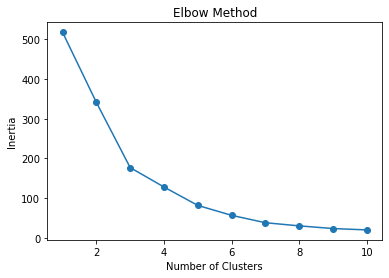%0A)

In \[61\]:

    import numpy as np
    import pandas as pd
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    # 데이터 로드
    df = pd.read_csv('data.csv', encoding='euc-kr')

    # 데이터 전처리
    X = df[['Latitude', 'Longitude']]
    weights = df['인구수'].values

    # K-means 클러스터링과 실루엣 점수 계산을 위한 반복문
    max_clusters = 10  # 최대 클러스터 개수 설정
    best_score = -1  # 최고 실루엣 점수 초기값 설정
    best_clusters = 0  # 최고 실루엣 점수에 해당하는 클러스터 개수 초기값 설정

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42).fit(X, sample_weight=weights)
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(X, cluster_labels)
        
        # 실루엣 점수가 최고값인 경우 결과 저장
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_clusters = n_clusters

    # 최고 실루엣 점수에 해당하는 클러스터 개수로 K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=best_clusters, init='k-means++', random_state=42).fit(X, sample_weight=weights)
    df['cluster'] = kmeans.labels_

    # 클러스터링 결과 시각화 등 추가 작업 수행

    # 최적의 클러스터 개수와 실루엣 점수 출력
    print("Optimal number of clusters:", best_clusters)
    print("Silhouette score:", best_score)

    Optimal number of clusters: 2
    Silhouette score: 0.4045046352929547

In \[60\]:

    import numpy as np
    import pandas as pd
    import folium
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    # 데이터 로드
    df = pd.read_csv('data.csv',encoding='euc-kr')

    # 서울 중심 좌표
    seoul_lat, seoul_lon = 37.566345, 126.977893

    # folium 지도 객체 생성
    kluster_map = folium.Map(location=[seoul_lat, seoul_lon], zoom_start=11)

    # k-means 클러스터링
    X = df[['Latitude', 'Longitude']]
    weights = df['인구수'].values
    max_clusters = 15
    silhouette_scores = np.zeros((max_clusters-2,))

    for i in range(2, max_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42).fit(X, sample_weight=weights)
        df['cluster'] = kmeans.labels_
        
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores[i-2] = silhouette_avg
        print(f"Done with cluster size {i}. Silhouette score: {silhouette_avg}")
        
        sample_silhouette_values = silhouette_samples(X, kmeans.labels_)

        # 클러스터링 결과 시각화
        cluster_centers = kmeans.cluster_centers_  # 클러스터 중심 좌표

        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        y_lower = 10
        for j in range(i):
            ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == j]
            ith_cluster_silhouette_values.sort()
            size_cluster_j = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_j
            color = cm.nipy_spectral(float(j) / i)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
            y_lower = y_upper + 10

        ax.set_title("The silhouette plot for the various clusters.", fontsize=14)
        ax.set_xlabel("The silhouette coefficient values", fontsize=12)
        ax.set_ylabel("Cluster label", fontsize=12)
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_yticks([])  
        ax.set_xlim([-0.1, 1])

        plt.show()

    # 실루엣 스코어 시각화
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(7, 7)

    ax.plot(range(2, max_clusters), silhouette_scores)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Silhouette score')
    ax.set_xticks(range(2, max_clusters))
    ax.set_title('Silhouette score for each cluster size')

    plt.show()

    Done with cluster size 2. Silhouette score: 0.4045046352929547

![](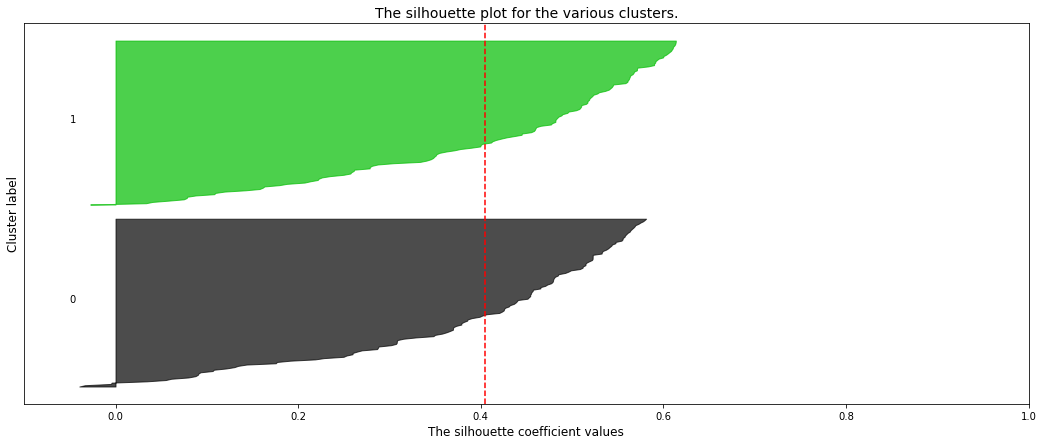%0A)

    Done with cluster size 3. Silhouette score: 0.3163666820615192

![](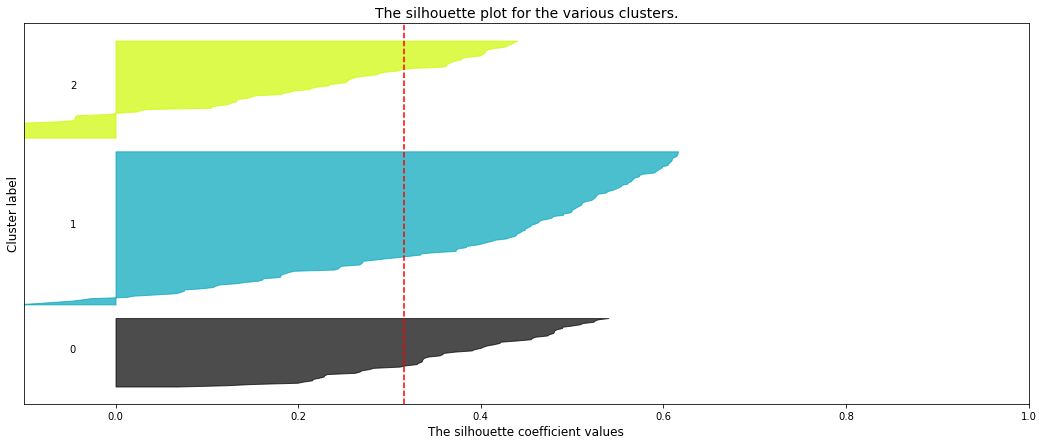%0A)

    Done with cluster size 4. Silhouette score: 0.27639217395540133

![](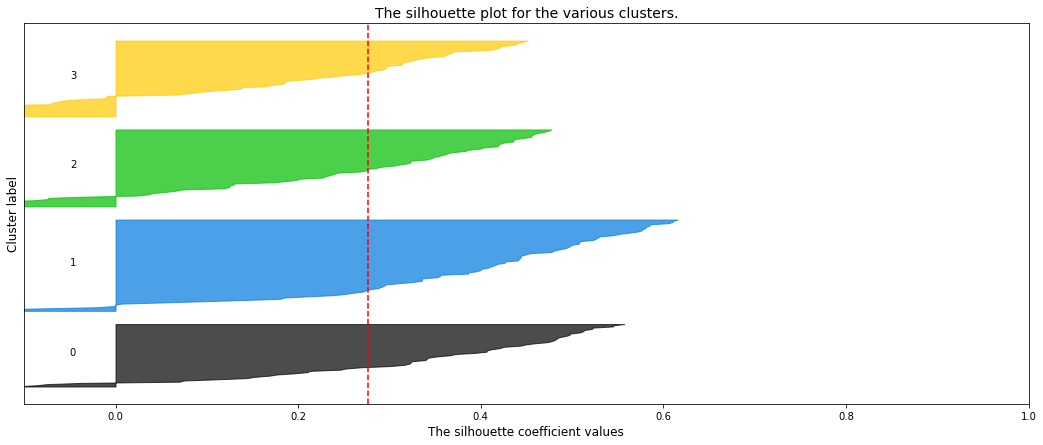%0A)

    Done with cluster size 5. Silhouette score: 0.29645206768596677

![](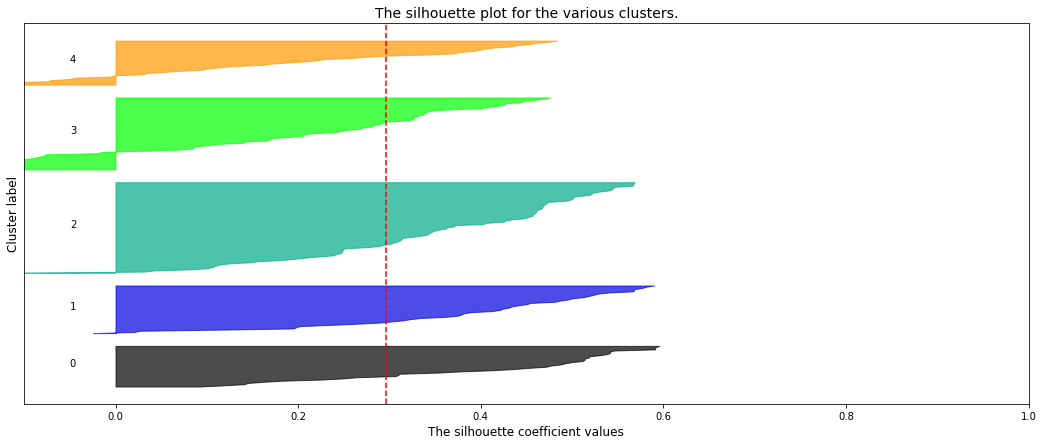%0A)

    Done with cluster size 6. Silhouette score: 0.3021191284553947

![](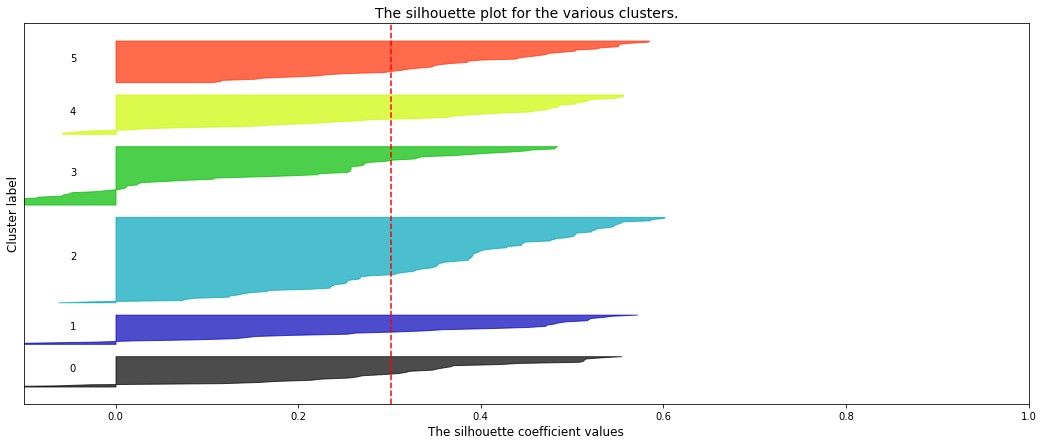%0A)

    Done with cluster size 7. Silhouette score: 0.3175490747980975

![](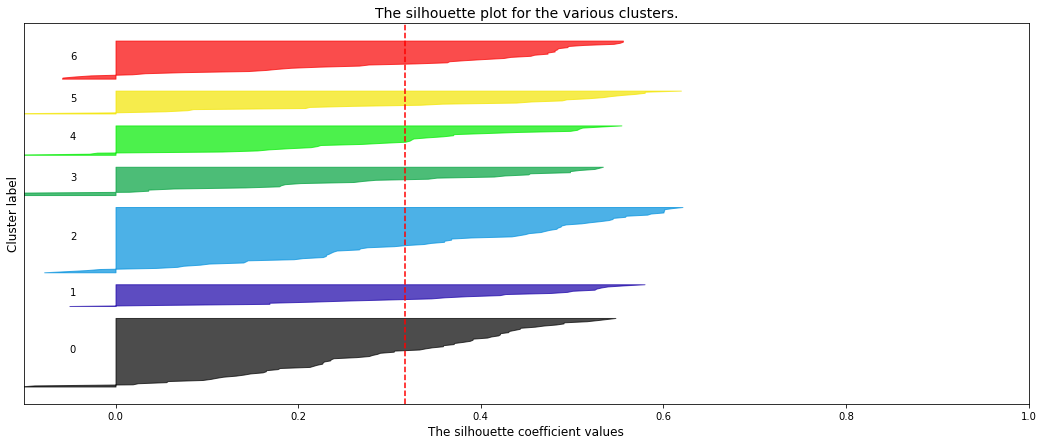%0A)

    Done with cluster size 8. Silhouette score: 0.31552519961161307

![](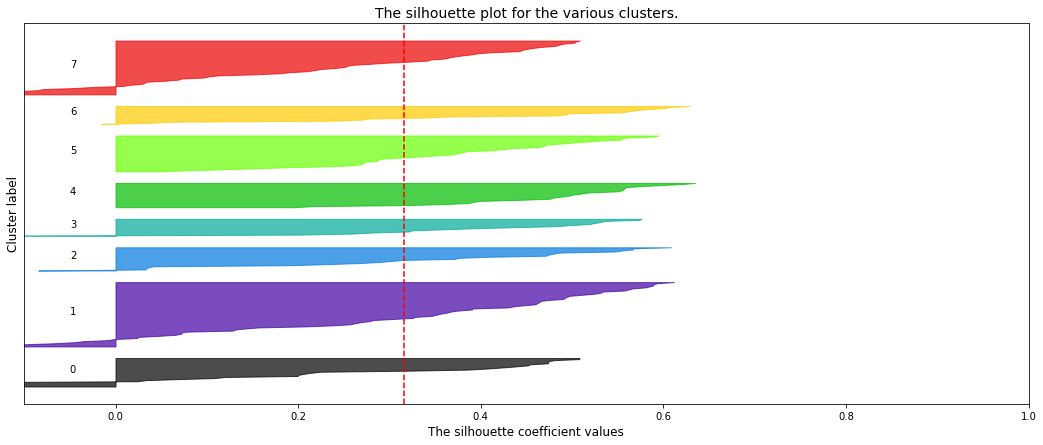%0A)

    Done with cluster size 9. Silhouette score: 0.3146759044144633

![](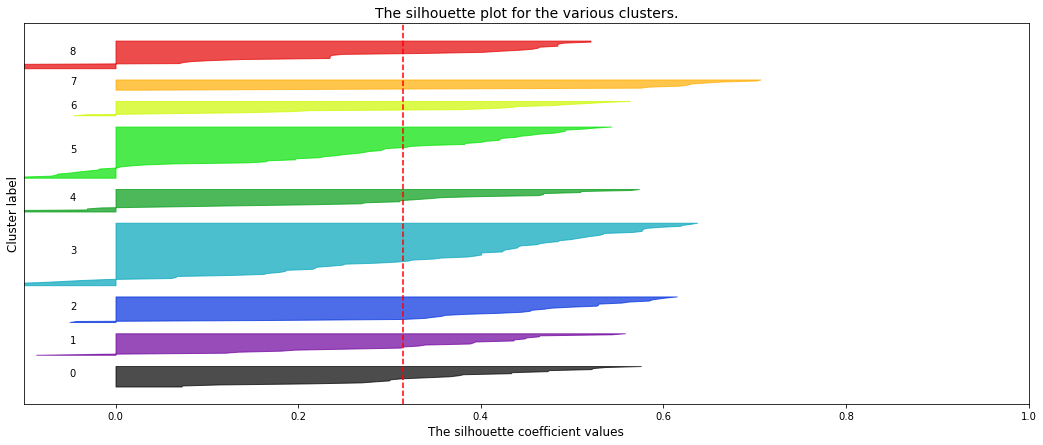%0A)

    Done with cluster size 10. Silhouette score: 0.29666016625637126

![](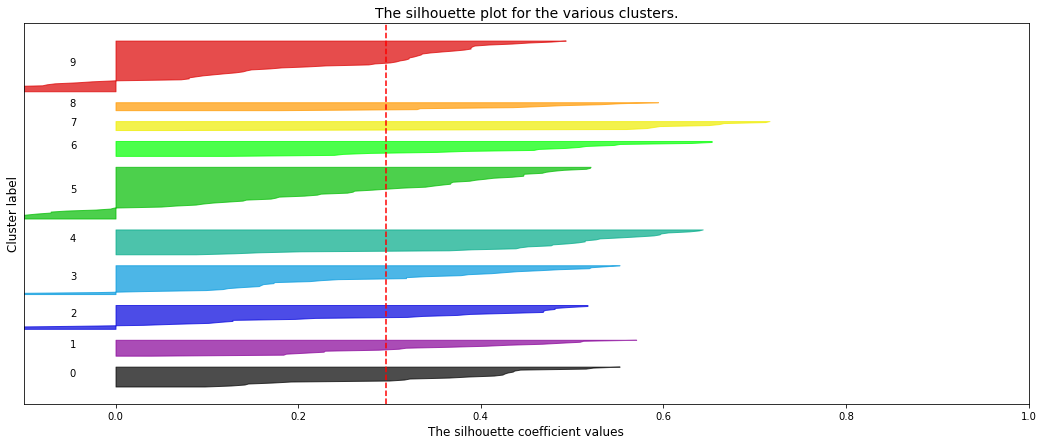%0A)

    Done with cluster size 11. Silhouette score: 0.3094243498429601

![](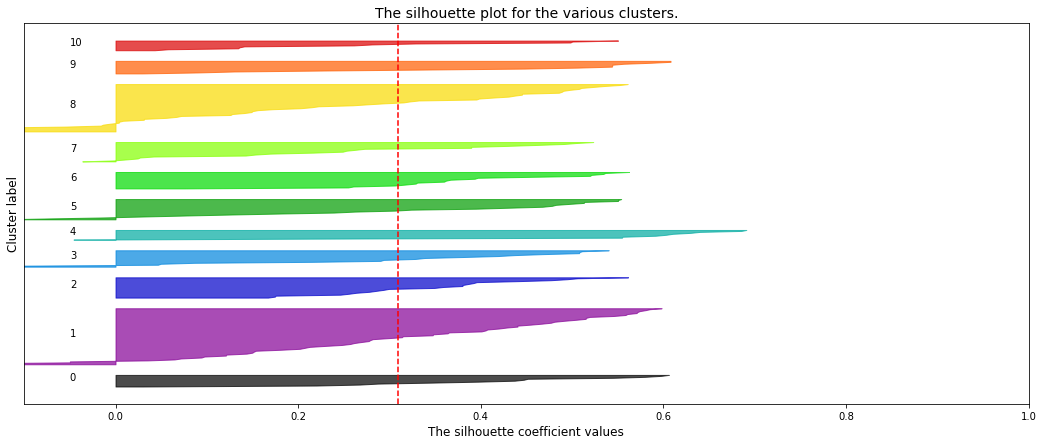%0A)

    Done with cluster size 12. Silhouette score: 0.3174452832447343

![](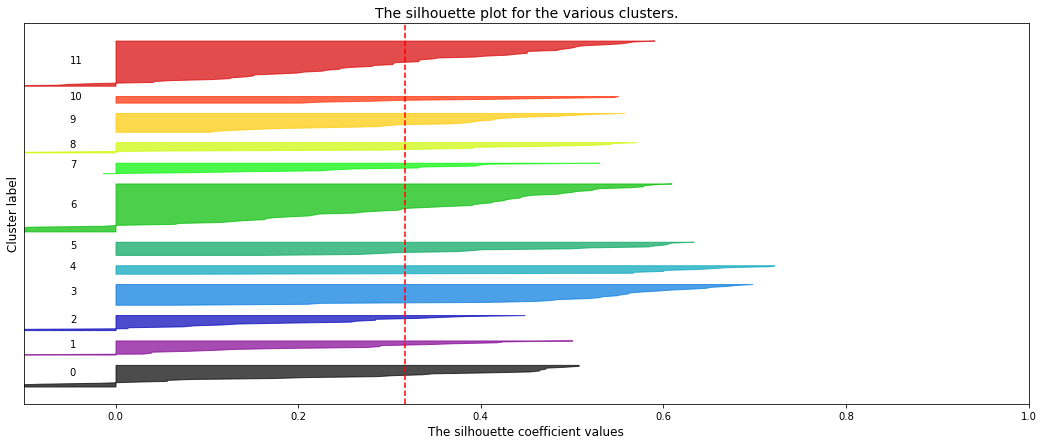%0A)

    Done with cluster size 13. Silhouette score: 0.32818083477044385

![](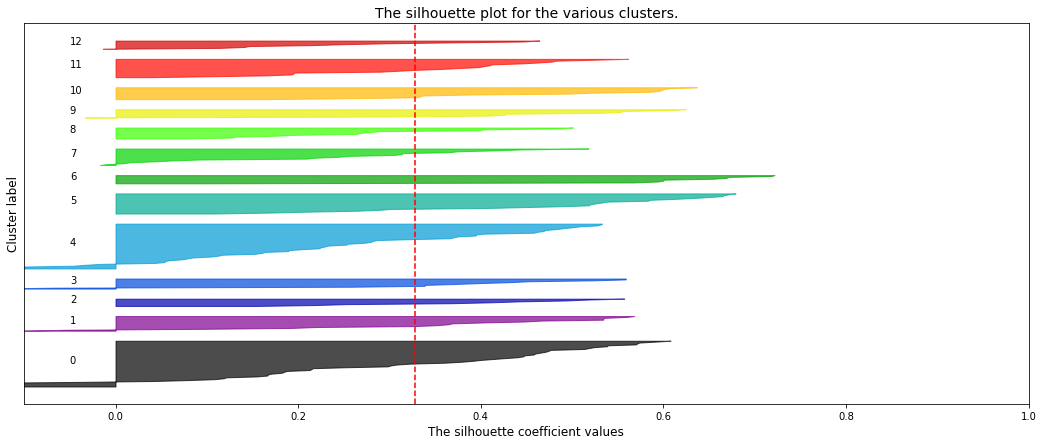%0A)

    Done with cluster size 14. Silhouette score: 0.3462330160895603

![](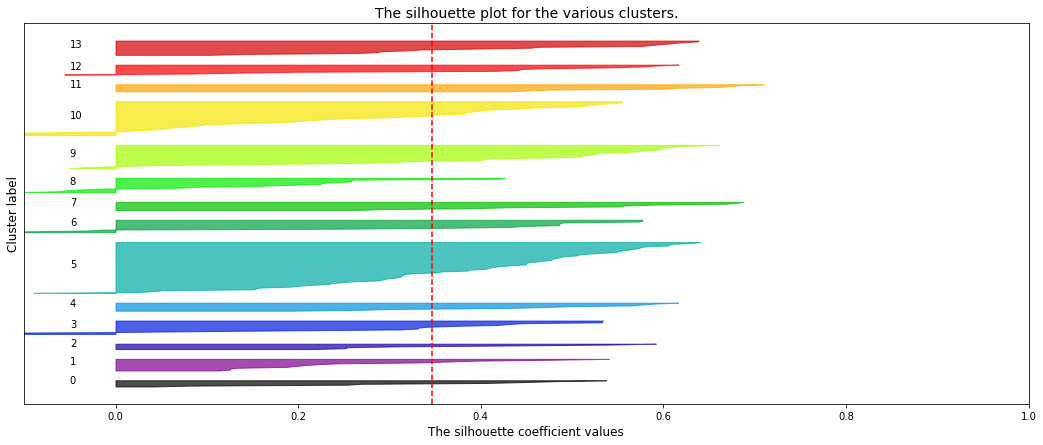%0A)

![](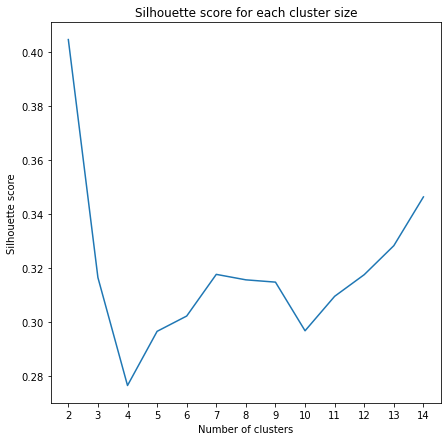%0A)

In \[62\]:

    import numpy as np
    import pandas as pd
    import folium
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler

    # 데이터 로드
    df = pd.read_csv('data.csv', encoding='euc-kr')

    # 필요한 열 선택
    selected_data = df[['법정동', '인구수', '물류창고 개수', 'Latitude', 'Longitude']]

    # 인구수와 물류창고 개수를 표준화
    scaler = StandardScaler()
    selected_data[['인구수', '물류창고 개수']] = scaler.fit_transform(selected_data[['인구수', '물류창고 개수']])

    # k-means 클러스터링
    X = selected_data[['인구수', '물류창고 개수']]
    kmeans = KMeans(n_clusters=7, init='k-means++', random_state=42).fit(X)
    selected_data['cluster'] = kmeans.labels_

    # 클러스터링 결과 시각화
    seoul_lat, seoul_lon = 37.566345, 126.977893
    kluster_map = folium.Map(location=[seoul_lat, seoul_lon], zoom_start=11)

    cluster_centers = kmeans.cluster_centers_

    for i in range(len(cluster_centers)):
        folium.Marker([cluster_centers[i][0], cluster_centers[i][1]],
                      icon=folium.Icon(color='red', icon='info-sign'),
                      popup='Cluster ' + str(i+1)).add_to(kluster_map)

    # 클러스터에 속하는 데이터 포인트의 중심점에 마커 추가
    for cluster_label in range(len(cluster_centers)):
        cluster_data = selected_data[selected_data['cluster'] == cluster_label]
        cluster_center_lat = cluster_data['Latitude'].mean()
        cluster_center_lon = cluster_data['Longitude'].mean()
        folium.Marker([cluster_center_lat, cluster_center_lon],
                      icon=folium.Icon(color='blue')).add_to(kluster_map)

    kluster_map

    C:\anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      self[col] = igetitem(value, i)
    C:\Users\한지성\AppData\Local\Temp/ipykernel_8636/1123793537.py:20: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      selected_data['cluster'] = kmeans.labels_

Out\[62\]:

<span style="color:#565656">Make this Notebook Trusted to load map: File
-\> Trust Notebook</span>

In \[ \]: